In [57]:
import numpy as np
from matplotlib import pyplot as plt
backend = plt.get_backend()
import jpcm
plt.switch_backend(backend)

In [52]:
s,t = np.mgrid[0:1:7j, 0:2*np.pi:7j]

In [61]:
def alp(R,r,t):
    A = R + r*np.cos(0.5*t)
    return np.array([A*np.cos(t),A*np.sin(t),r*np.sin(0.5*t)])
def beta(R,r,t):
    B = R + r*np.cos(np.pi+0.5*t)
    return np.array([B*np.cos(t),B*np.sin(t),r*np.sin(np.pi+0.5*t)])
def sig(s,t,R,r):
    return (1-s)*alp(R,r,t) + s*beta(R,r,t)

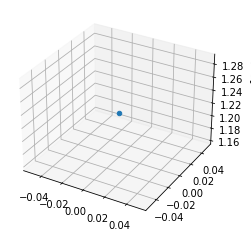

In [62]:
a,b,c = sig(s,t,1,1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=a,ys=b,zs=c)
plt.show()

In [63]:
u,v = np.mgrid[0:11:12j, 0:11:12j]
u=u.flatten()
v=v.flatten()

In [64]:
v2 = (6 + v)%12
x = (u + (v2%12 - 6))
y = (-u + v2)


In [65]:
ix = (y<=6) & (x>=0) & (x<12) & (y>=-6)
u = u[ix]
v = v[ix]
x = x[ix]
y = y[ix]

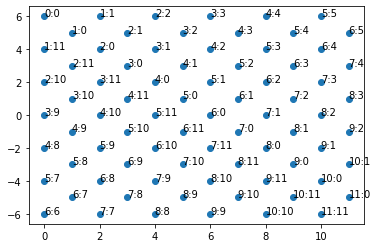

In [66]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x,y)
toXYZ = {}
iST ={}
for i, txt in enumerate(x):
    ax.annotate(f'{int(u[i])}:{int(v[i])}', (x[i], y[i]))
    s = (y[i]+6)/12
    t = 2*np.pi*(x[i]/12)
    toXYZ[f'{int(u[i])}:{int(v[i])}'] = sig(s,t,1,1)
    toXYZ[f'{int(v[i])}:{int(u[i])}'] = sig(s,t,1,1)
    iST[f'{int(u[i])}:{int(v[i])}'] = [s,t]
    iST[f'{int(v[i])}:{int(u[i])}'] = [s,t]
plt.show()

In [67]:
iST

{'0:0': [1.0, 0.0],
 '1:0': [0.91666666666666663, 0.52359877559829882],
 '0:1': [0.91666666666666663, 0.52359877559829882],
 '1:1': [1.0, 1.0471975511965976],
 '1:11': [0.83333333333333337, 0.0],
 '11:1': [0.83333333333333337, 0.0],
 '2:0': [0.83333333333333337, 1.0471975511965976],
 '0:2': [0.83333333333333337, 1.0471975511965976],
 '2:1': [0.91666666666666663, 1.5707963267948966],
 '1:2': [0.91666666666666663, 1.5707963267948966],
 '2:2': [1.0, 2.0943951023931953],
 '2:10': [0.66666666666666663, 0.0],
 '10:2': [0.66666666666666663, 0.0],
 '2:11': [0.75, 0.52359877559829882],
 '11:2': [0.75, 0.52359877559829882],
 '3:0': [0.75, 1.5707963267948966],
 '0:3': [0.75, 1.5707963267948966],
 '3:1': [0.83333333333333337, 2.0943951023931953],
 '1:3': [0.83333333333333337, 2.0943951023931953],
 '3:2': [0.91666666666666663, 2.6179938779914944],
 '2:3': [0.91666666666666663, 2.6179938779914944],
 '3:3': [1.0, 3.1415926535897931],
 '3:9': [0.5, 0.0],
 '9:3': [0.5, 0.0],
 '3:10': [0.583333333333333

In [16]:
import musicpy as mp
from scipy import stats
import  numpy as np

In [70]:
cfr = mp.read('midi/Beethoven_-_Moonlight_Sonata_1stMvt.mid')
t1 = cfr.tracks[0]

In [71]:
d = c.get_degree()
np.unique((np.sort(np.array(d) - min(d)))%12)

AttributeError: 'numpy.float64' object has no attribute 'get_degree'

In [72]:
nms = np.array(['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'])
def key_chord(chordname):
    cname = chordname
    if 'note' in cname:
        cname = chordname.replace('note','').replace(' ','')
    nm = cname[0]
    if cname[1] == '#':
        nm += '#'
    if nm in nms:
        return mp.note_to_degree(nm)%12
    if '[' in cname:
        # a of b style
        splits = cname.split(']/[')
        if len(splits) == 2:
            a,b =splits
        if len(splits) > 2:
            a = splits[0]
            b = splits[-1]
        if len(splits) == 1:
            return key_chord(splits[0].split('/')[0].replace('[','').replace(']',''))
        return [key_chord(b),key_chord(a[1:])]
    return 'ERROR'
def current_key(keys,w=8):
    n = len(keys)
    out =  [stats.mode(keys[max(i-w,0):i+1,1])[0][0] for i in range(n)]
    return np.array(out).astype(int)

In [73]:

# [print(key_chord(mp.detect(cs[i],mode='chord'))) for i in range(len(cs))]

In [74]:
cs = mp.chord_analysis(t1,mode='chords')
keys = [key_chord(mp.detect(c,mode='chord')) for c in cs]
keys = np.array([[0,a] if not isinstance(a,list) else a for a in keys])
c_key = current_key(keys)

In [75]:
def quality(cs):
    """Generate the quality matrix from the chord-progression
    Args: 
        cs (musicpy chord object): input chord-progression
    Returns:
        np.array : 3-column quality matrix
    """
    q = np.zeros(shape=(len(cs),3))
    for i in range(len(cs)):
        c = cs[i]
        d = np.unique(c.get_degree())
        a = min(d)
        e = (d-a)%12
        q[i,0] = 0
        if len(e) > 1:
            q[i,1] = e[1]
        else: 
            q[i,1] = 0
        q[i,2] = e[len(e)-1]
    return q

In [76]:
# quality(cs)

In [82]:
state = np.vstack([c_key,keys.T,quality(cs).T]).T
state.shape

(93, 6)

In [78]:
intervals = np.vstack([[f"{int(state[i,0])}:{int(state[i,1])}",f"{int(state[i,1])}:{int(state[i,2])}",
            f"{int(state[i,3])}:{int(state[i,4])}",f"{int(state[i,4])}:{int(state[i,5])}"] for i in range(len(state))])
intervals

array([['7:0', '0:7', '0:2', '2:2'],
       ['5:0', '0:5', '0:9', '9:0'],
       ['4:0', '0:4', '0:0', '0:0'],
       ['4:0', '0:4', '0:10', '10:0'],
       ['4:0', '0:9', '0:7', '7:7'],
       ['4:0', '0:4', '0:0', '0:0'],
       ['4:0', '0:2', '0:5', '5:8'],
       ['4:0', '0:7', '0:9', '9:9'],
       ['4:0', '0:7', '0:10', '10:0'],
       ['4:0', '0:5', '0:2', '2:2'],
       ['4:0', '0:0', '0:4', '4:4'],
       ['0:0', '0:0', '0:3', '3:3'],
       ['0:0', '0:3', '0:0', '0:0'],
       ['0:0', '0:10', '0:5', '5:5'],
       ['0:0', '0:8', '0:7', '7:7'],
       ['7:0', '0:7', '0:8', '8:8'],
       ['0:0', '0:3', '0:8', '8:9'],
       ['0:0', '0:0', '0:5', '5:8'],
       ['0:0', '0:2', '0:1', '1:1'],
       ['0:0', '0:7', '0:0', '0:0'],
       ['7:0', '0:7', '0:5', '5:0'],
       ['7:0', '0:7', '0:0', '0:0'],
       ['7:0', '0:7', '0:5', '5:0'],
       ['7:0', '0:4', '0:3', '3:3'],
       ['7:0', '0:10', '0:8', '8:9'],
       ['7:0', '0:2', '0:3', '3:5'],
       ['7:0', '0:8', '0:1', '1:

In [79]:
def toST(intervals):
    """Convert interval matrix to a ST-coordinate matrix (both np.ndarray elements)"""
    return np.array([[iST[rc] for rc in row] for row in intervals]) ### 4 (s,t) pairs for each chord element.
stcoord = toST(intervals)
print(stcoord.shape)
stcoord

(93, 4, 2)


array([[[ 0.41666667,  3.66519143],
        [ 0.41666667,  3.66519143],
        [ 0.83333333,  1.04719755],
        [ 1.        ,  2.0943951 ]],

       [[ 0.58333333,  2.61799388],
        [ 0.58333333,  2.61799388],
        [ 0.25      ,  4.71238898],
        [ 0.25      ,  4.71238898]],

       [[ 0.66666667,  2.0943951 ],
        [ 0.66666667,  2.0943951 ],
        [ 1.        ,  0.        ],
        [ 1.        ,  0.        ]],

       [[ 0.66666667,  2.0943951 ],
        [ 0.66666667,  2.0943951 ],
        [ 0.16666667,  5.23598776],
        [ 0.16666667,  5.23598776]],

       [[ 0.66666667,  2.0943951 ],
        [ 0.25      ,  4.71238898],
        [ 0.41666667,  3.66519143],
        [ 0.        ,  1.04719755]],

       [[ 0.66666667,  2.0943951 ],
        [ 0.66666667,  2.0943951 ],
        [ 1.        ,  0.        ],
        [ 1.        ,  0.        ]],

       [[ 0.66666667,  2.0943951 ],
        [ 0.83333333,  1.04719755],
        [ 0.58333333,  2.61799388],
        [ 0.25  

In [80]:
def motionST(stcoord):
    """simple differencing of the st coordinates (the input). 
    Returns a flattened difference array (both np.ndarray objects) with one less point (due to differencing)"""
    out = stcoord[1:] - stcoord[:len(stcoord)-1]
    out = [np.concatenate([out[i,:,0],out[i,:,1]]) for i in range(len(out))]
    return out
stdiff=motionST(stcoord)
stdiff

[array([ 0.16666667,  0.16666667, -0.58333333, -0.75      , -1.04719755,
        -1.04719755,  3.66519143,  2.61799388]),
 array([ 0.08333333,  0.08333333,  0.75      ,  0.75      , -0.52359878,
        -0.52359878, -4.71238898, -4.71238898]),
 array([ 0.        ,  0.        , -0.83333333, -0.83333333,  0.        ,
         0.        ,  5.23598776,  5.23598776]),
 array([ 0.        , -0.41666667,  0.25      , -0.16666667,  0.        ,
         2.61799388, -1.57079633, -4.1887902 ]),
 array([ 0.        ,  0.41666667,  0.58333333,  1.        ,  0.        ,
        -2.61799388, -3.66519143, -1.04719755]),
 array([ 0.        ,  0.16666667, -0.41666667, -0.75      ,  0.        ,
        -1.04719755,  2.61799388,  0.52359878]),
 array([ 0.        , -0.41666667, -0.33333333, -0.25      ,  0.        ,
         2.61799388,  2.0943951 ,  2.61799388]),
 array([ 0.        ,  0.        , -0.08333333,  0.16666667,  0.        ,
         0.        ,  0.52359878,  2.0943951 ]),
 array([ 0.        ,  0.

In [98]:
import utils as ul
import chords as cd
def analyze(chord:mp.track, type:int, width:int=1) -> list:
    """Run Chord Analysis and get emotional vector data

    Args:
        chord (mp.track): musicpy track to run analysis on
        type (int): is this a progression or a full song?
        width (int, optional): kernel width for postprocessing analysis. Defaults to 1.

    Returns:
        list: chord start times, chords as mp objects, chord names, and the emotional value matrix (not regular in time)
    """
    chordNames = chord.chord_analysis(get_original_order=True, is_chord=(type==1))
    chords = chord.chord_analysis(get_original_order=True,mode='chords',is_chord=(type==1))

    bars = np.cumsum([np.sum(c.interval) for c in chords])
    
    kernel = np.ones((width,ul.n_keys))/(width*ul.n_keys)
    data = np.zeros((len(chordNames),ul.n_keys))
    for i in range(len(chordNames)):
        data[i,:] = cd.value(chordNames[i])
    data = sig.convolve2d(data, kernel, mode='same')
    
    return bars, chords, chordNames, data
bars, chords, _, data = analyze(cfr.tracks[0], type)

ImportError: attempted relative import with no known parent package

In [103]:
    chords = cfr.tracks[0].chord_analysis(get_original_order=True,mode='chords',is_chord=(type==1))

    bars = np.cumsum([np.sum(c.interval) for c in chords])
    print(len(bars))
    print(len(chords))
    bars

93
93


array([   3.    ,    4.5   ,    4.875 ,    6.    ,    7.125 ,    9.    ,
         10.5   ,   10.625 ,   11.625 ,   12.    ,   13.5   ,   13.875 ,
         15.    ,   16.5   ,   16.875 ,   17.25  ,   18.    ,   19.125 ,
         21.    ,   22.875 ,   25.125 ,   25.875 ,   27.75  ,   27.875 ,
         28.875 ,   30.    ,   30.875 ,   31.5   ,   34.5   ,   34.875 ,
         36.    ,   36.75  ,   37.5   ,   37.625 ,   38.75  ,   39.3125,
         39.75  ,   40.25  ,   41.375 ,   43.5   ,   45.    ,   45.125 ,
         45.5   ,   46.5   ,   48.    ,   48.125 ,   49.5   ,   49.625 ,
         50.    ,   51.125 ,   55.5   ,   59.25  ,   60.    ,   60.75  ,
         61.125 ,   63.    ,   64.5   ,   66.    ,   66.125 ,   67.125 ,
         67.5   ,   69.    ,   69.375 ,   70.5   ,   70.875 ,   71.625 ,
         71.75  ,   72.125 ,   73.125 ,   74.25  ,   75.125 ,   76.875 ,
         78.    ,   79.125 ,   79.875 ,   81.    ,   82.5   ,   82.875 ,
         83.625 ,   84.375 ,   84.75  ,   85.5   , 

In [ ]:
help(mp.negative_harmony)
help(mp.random_composing)

Help on function negative_harmony in module musicpy.musicpy:

negative_harmony(key, current_chord=None, sort=False, get_map=False)

Help on function random_composing in module musicpy.musicpy:

random_composing(mode, length, difficulty='easy', init_notes=None, pattern=None, focus_notes=None, focus_ratio=0.7, avoid_dim_5=True, num=3, left_hand_velocity=70, right_hand_velocity=80, left_hand_meter=4, right_hand_meter=4, choose_intervals=[0.125, 0.25, 0.5], choose_durations=[0.125, 0.25, 0.5], melody_interval_tol=5, choose_from_chord=False)



In [86]:
import musicpy as mp
import json as js

In [2]:
A1 = mp.C('Cm7') % (0.5, 8/8)
B1 = mp.C('Dsus') % (0.5, 1/8)
C1 = mp.C('Caug7') % (0.5, 1/8)
D1 = mp.C('Dadd2') % (0.5, 1/8)
A2 = mp.C('Cm7') % (0.5, 1/8)
B2 = mp.C('Dsus') % (0.5, 1/8)
C2 = mp.C('Caug7') % (0.5, 1/8)
D2 = mp.C('D,G,A,A# / Dadd2') % (0.5, 1/4)

new_piece =  mp.piece([A1, B1, C1, D1, A2, B2, C2, D2],
                  ['Acoustic Grand Piano'] * 8,
                  175,
                  [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5],
                  ['0']*8)

In [4]:
bpm, b, start_time = new_piece.merge()
p = mp.build(mp.track(b),bpm=bpm,name='piece')

In [12]:
list(p.tracks[0].notes)

[C4,
 D4,
 G4,
 A4,
 D#4,
 C4,
 E4,
 G#4,
 A#4,
 D4,
 E4,
 F#4,
 A4,
 G4,
 C4,
 D#4,
 G4,
 A#4,
 D4,
 G4,
 A4,
 A#4,
 C4,
 E4,
 G#4,
 A#4,
 D4,
 E4,
 F#4,
 A4,
 D5,
 F#5,
 A5]

In [185]:
[
    {
        'chd' : 'Cmaj7',
        'time': 1,
        'arp' : 1/8,
        'start': 0,
        'inst' : 'Acoustic Grand Piano'
    },
    {
        'chd' : 'A2',
        'time': 1,
        'arp' : 1,
        'start': 2,
        'inst' : 'Acoustic Grand Piano'
    }
]

[{'chd': 'Cmaj7',
  'time': 1,
  'arp': 0.125,
  'start': 0,
  'inst': 'Acoustic Grand Piano'},
 {'chd': 'A2',
  'time': 1,
  'arp': 1,
  'start': 2,
  'inst': 'Acoustic Grand Piano'}]

In [189]:
def convert_to_mp(chp : list, bpm : float=138, name: str='Progression 0') -> mp.piece:
    """Convert a chord-progression from a dict `chd` to a musicpy object

    Args:
        chp (list): chord progression
        bpm (float): BPM to play the song at.

    Returns:
        mp.piece: musicpy piece from chord progression
    """
    chord = [mp.C(i['chd']) % (i['time'], i['arp']) for i in chp]
    inst = [i['inst'] for i in chp]
    start = [i['start'] for i in chp]
    bpm, chdnotes, _ = mp.piece(chord,inst,bpm,start,['0']*len(chord)).merge()
    return mp.build(mp.track(chdnotes),bpm=bpm,name=name)

In [218]:
json = js.loads("""[{
			"chd": "Cm7",
			"time": 0.5,
			"arp": 0.125,
			"start": 0,
			"inst": "Acoustic Grand Piano"
		},
		{
			"chd": "Dsus",
			"time": 0.5,
			"arp": 0.125,
			"start": 0.5,
			"inst": "Acoustic Grand Piano"
		},
		{
			"chd": "Caug7",
			"time": 0.5,
			"arp": 0.125,
			"start": 1,
			"inst": "Acoustic Grand Piano"
		},
		{
			"chd": "Dadd2",
			"time": 0.5,
			"arp": 0.125,
			"start": 1.5,
			"inst": "Acoustic Grand Piano"
		},
		{
			"chd": "Cm7",
			"time": 0.5,
			"arp": 0.125,
			"start": 2,
			"inst": "Acoustic Grand Piano"
		},
		{
			"chd": "Gsus",
			"time": 0.5,
			"arp": 0.125,
			"start": 2.5,
			"inst": "Acoustic Grand Piano"
		},
		{
			"chd": "Gaug7",
			"time": 0.5,
			"arp": 0.125,
			"start": 3,
			"inst": "Acoustic Grand Piano"
		},
		{
			"chd": "D,G,A,A# / Dadd2",
			"time": 0.5,
			"arp": 0.25,
			"start": 3.5,
			"inst": "Acoustic Grand Piano"
		}
	]""")

In [215]:
piece=convert_to_mp(chp=json, bpm=138, name='Progression 0')

In [216]:
piece.play()

In [219]:
piece.tracks[0]

[C4, D#4, G4, A#4, D4, G4, A4, C4, E4, G#4, A#4, D4, E4, F#4, A4, C4, D#4, G4, A#4, G4, C5, D5, G4, B4, D#5, F5, D4, E4, F#4, A4, D5, F#5, A5] with interval [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.25, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.25, 0.125, 0.125, 0.125, 0.125, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5]

In [213]:
piece

[piece] Progression 0
BPM: 138
track 1 | instrument: Acoustic Grand Piano | start time: 0 | [C4, D#4, G4, A#4, D4, G4, A4, C4, E4, G#4, A#4, D4, E4, F#4, A4, C4, D#4, G4, A#4, G4, C5, D5, C4, E4, G#4, A#4, D4, E4, F#4, A4, D5, F#5, A5] with interval [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.25, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.25, 0.125, 0.125, 0.125, 0.125, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5]

In [221]:
mp.chord_analysis(piece.tracks[0])

['Cmaj13#11 omit B, G sort as [1, 3, 2, 4, 5]']